توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [ ]:
## download data

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt
!pip install mmengine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.3/450.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 28.1 MB/s eta 0:00:00


## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [4]:
# function 1
def displacement(img):
    rows, cols, _ = img.shape
    # Define amount of displacement
    dx = 50
    dy = 50
    # Define the transformation matrix for displacement
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    # Use warpAffine to apply the displacement
    img = cv2.warpAffine(img, M, (cols, rows))[dx:,dy:,:]
    return img

# function 2
def rotation(img):
    ## To Do
    return img

# function 3
def scaling(img):
    img = cv2.resize(img, (224, 224))
    return img

# function 4
def Brightness(img):  ## for augmentation
    img = np.clip(img * 1.6, 0, 255)
    img = img.astype(np.uint8)
    return img

# function 5
def bluring(img):# for augmentation
    img = cv2.GaussianBlur(img, (5, 5), 0, 0)
    return img

# function 6
def gaussian_noise(img):#for augmentation
    row, col, ch = img.shape
    gauss = np.random.normal(0, 20, (row, col, ch))
    img = img + gauss
    # Clip values to the valid range [0, 255]
    img = np.clip(img, 0, 255)
    img = img.astype(np.uint8)
    return img

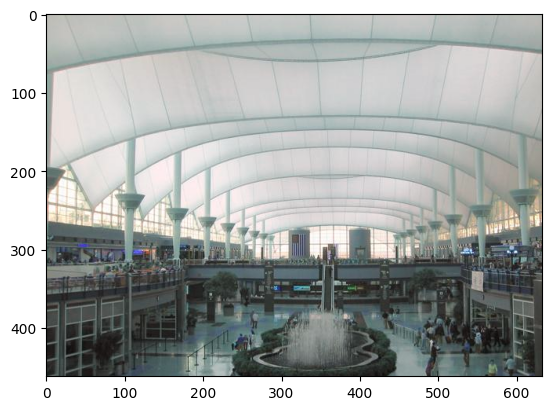

In [ ]:
plt.imshow(displacement(cv2.imread('/content/ADEChallengeData2016/images/training/ADE_train_00000001.jpg')))

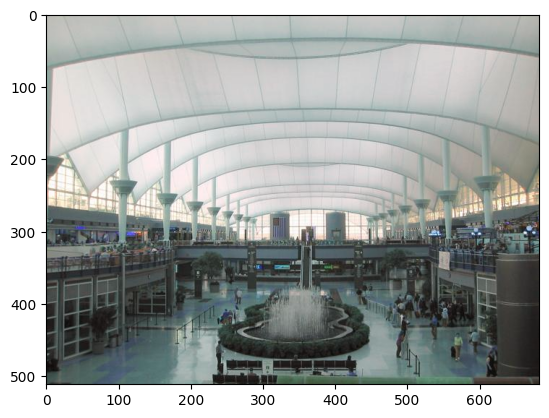

In [ ]:
plt.imshow(cv2.imread('/content/ADEChallengeData2016/images/training/ADE_train_00000001.jpg'))

In [ ]:
class CustomDataset(Dataset):

    def __init__(self,):
      ## To Do

    def __getitem__(self,idx):
      ## To Do

    def __len__(self):
      ## To Do


In [ ]:

dataset_train = CustomDataset()## To Do
dataset_test = CustomDataset()## To Do
dataset_val = CustomDataset()## To Do


train_loader = DataLoader()## To Do
test_loader= DataLoader()## To Do
val_loader = DataLoader()## To Do


In [ ]:
## To Do  : show 8 images from train_loader & 8 images from test_loader



##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

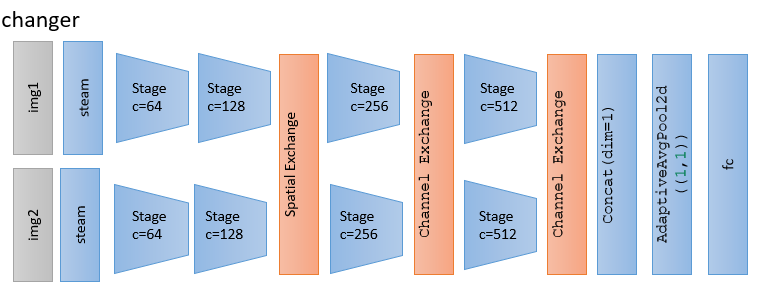

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


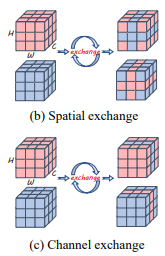

In [5]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

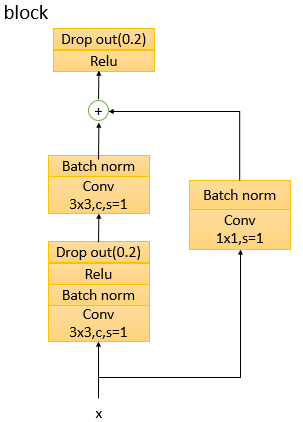

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





  بایستی تعداد کانال های خروجی کانوولوشن یک در یک برابر با همان کانال های خروجی مسیر سمت چپ که همان  تعداد فیلترهای هر کانوولوشن میباشد باشد یعنی همان مقدارc

با توجه به اینکه سایز فیلترها سه در سه است مقدار پدینگ را یک واحد درنظر گرفتم.

برای تنظیم تعداد کانال ها تا بتوان خروجی مسیر چپ را با مسیر راست جمع کنیم باید تعداد کانال ها یکسان باشد که این کار را با استفاده از کانوولوشن یک در یک انجام میدهیم.

In [6]:
##To Do
class block(nn.Module):
      def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dropout_prob=0.2):
          super(block,self).__init__()

          self.forwardPath = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout_prob),
                nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(out_channels))

          self.resPath = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(out_channels))

          self.finalPath = nn.Sequential(
              nn.ReLU(inplace=True),
              nn.Dropout2d(p=dropout_prob))

      def forward(self,x):
          forwardpath_out = self.forwardPath(x)
          respath_out = self.resPath(x)
          out = self.finalPath(forwardpath_out+respath_out)
          return out

In [7]:
# Example usage:
input_channels = 64
output_channels = 128

blockmodel = block(input_channels, output_channels)
print(blockmodel)
input_data = torch.randn((1,64, 112, 112))

output_data = blockmodel(input_data)
print("Output shape:", output_data.shape)

block(
  (forwardPath): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (resPath): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (finalPath): Sequential(
    (0): ReLU(inplace=True)
    (1): Dropout2d(p=0.2, inplace=False)
  )
)
Output shape: torch.Size([1, 128, 112, 112])


In [ ]:
# import torch
# import torch.nn as nn

# class BasicBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dropout_prob=0.2):
#         super(BasicBlock, self).__init__()

#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
#         self.batchnorm1 = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
#         self.dropout = nn.Dropout2d(p=dropout_prob)

#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding)
#         self.batchnorm2 = nn.BatchNorm2d(out_channels)

#         # If the input and output channels are different, use a 1x1 convolution for the skip connection
#         if in_channels != out_channels or stride != 1:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
#                 nn.BatchNorm2d(out_channels)
#             )
#         else:
#             self.shortcut = nn.Identity()

#     def forward(self, x):
#         residual = self.shortcut(x)

#         x = self.conv1(x)
#         x = self.batchnorm1(x)
#         x = self.relu(x)
#         x = self.dropout(x)

#         x = self.conv2(x)
#         x = self.batchnorm2(x)

#         x += residual  # Add the skip connection

#         x = self.relu(x)

#         return x

# # Example usage:
# input_channels = 3
# output_channels = 64

# block = BasicBlock(input_channels, output_channels)
# input_data = torch.randn((1, input_channels, 224, 224))  # Adjust input size as needed

# output_data = block(input_data)
# print("Output shape:", output_data.shape)


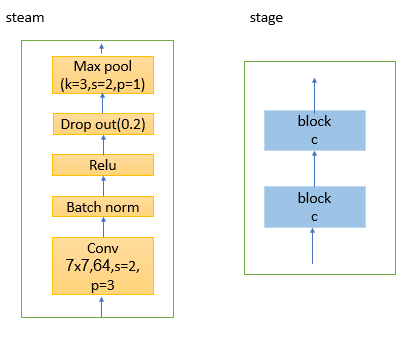

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [8]:
#To Do
class changer(nn.Module):
  def __init__(self,block,SpatialExchange,ChannelExchange):
    super(changer,self).__init__()

    self.steam=nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
          nn.BatchNorm2d(64),
          nn.ReLU(inplace=True),
          nn.Dropout2d(p=0.2),
          nn.MaxPool2d(kernel_size=3, stride=1, padding=1))

    self.stage1 = nn.Sequential(block(in_channels=64, out_channels=64), block(in_channels=64, out_channels=64))
    self.stage2 = nn.Sequential(block(in_channels=64, out_channels=128), block(in_channels=128, out_channels=128))
    self.stage3 = nn.Sequential(block(in_channels=128, out_channels=256), block(in_channels=256, out_channels=256))
    self.stage4 = nn.Sequential(block(in_channels=256, out_channels=512), block(in_channels=512, out_channels=512))

    self.spatial_ex = SpatialExchange()
    self.channel_ex_1 = ChannelExchange()
    self.channel_ex_2 = ChannelExchange()

    self.fc = nn.Linear(1024, 3)


  def _make_stage(self,):

    layers = [self.steam, self.stage1, self.stage2]

    return nn.Sequential(*layers)




  def forward(self,x1,x2):
    out_1 = self._make_stage()(x1)
    out_2 = self._make_stage()(x2)
    out_1,out2 = self.spatial_ex(out_1, out_2)
    out_1 = self.stage3(out_1)
    out_2 = self.stage3(out_2)
    out_1, out_2 = self.channel_ex_1(out_1, out_2)
    out_1 = self.stage4(out_1)
    out_2 = self.stage4(out_2)
    out_1, out_2 = self.channel_ex_2(out_1, out_2)
    combined_output = torch.cat((out_1, out_2), dim=1)
    # Apply Adaptive Average Pooling
    combined_output = nn.AdaptiveAvgPool2d(1)(combined_output)
    # Flatten the output before passing it through the final layer
    combined_output = combined_output.view(combined_output.size(0), -1)
    # FC layer
    out = self.fc(combined_output)

    return out

In [11]:
#To Do
class changer(nn.Module):
  def __init__(self,block,SpatialExchange,ChannelExchange):
    super(changer,self).__init__()

    self.steam=nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
          nn.BatchNorm2d(64),
          nn.ReLU(inplace=True),
          nn.Dropout2d(p=0.2),
          nn.MaxPool2d(kernel_size=3, stride=1, padding=1))

    self.stage1 = self._make_stage(block(in_channels=64, out_channels=64), block(in_channels=64, out_channels=64))
    self.stage2 = self._make_stage(block(in_channels=64, out_channels=128), block(in_channels=128, out_channels=128))
    self.stage3 = self._make_stage(block(in_channels=128, out_channels=256), block(in_channels=256, out_channels=256))
    self.stage4 = self._make_stage(block(in_channels=256, out_channels=512), block(in_channels=512, out_channels=512))

    self.spatial_ex = SpatialExchange()
    self.channel_ex_1 = ChannelExchange()
    self.channel_ex_2 = ChannelExchange()

    self.fc = nn.Linear(1024, 3)


  def _make_stage(self, block_1, block_2):

    layers = [block_1, block_2]

    return nn.Sequential(*layers)



  def forward(self,x1,x2):
    out_1 = self.steam(x1)
    out_2 = self.steam(x2)

    out_1 = self.stage1(out_1)
    out_2 = self.stage1(out_2)

    out_1 = self.stage2(out_1)
    out_2 = self.stage2(out_2)

    out_1,out2 = self.spatial_ex(out_1, out_2)

    out_1 = self.stage3(out_1)
    out_2 = self.stage3(out_2)

    out_1, out_2 = self.channel_ex_1(out_1, out_2)

    out_1 = self.stage4(out_1)
    out_2 = self.stage4(out_2)

    out_1, out_2 = self.channel_ex_2(out_1, out_2)

    combined_output = torch.cat((out_1, out_2), dim=1)

    combined_output = nn.AdaptiveAvgPool2d(1)(combined_output)

    combined_output = combined_output.view(combined_output.size(0), -1)

    out = self.fc(combined_output)

    return out

In [12]:
input_tensor1 = torch.randn((1, 3, 224, 224))
input_tensor2 = torch.randn((1, 3, 224, 224))
model_temp=changer(block,SpatialExchange,ChannelExchange)

print(model_temp)

output_data = model_temp(input_tensor1, input_tensor2)
print("Output shape:", output_data.shape)
print(output_data)

changer(
  (steam): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (stage1): Sequential(
    (0): block(
      (forwardPath): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout2d(p=0.2, inplace=False)
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (resPath): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

In [ ]:
## To Do
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


model=changer(block,SpatialExchange,ChannelExchange).to(device)

citeration = nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(model.parameters(), lr=0.001)

##Train & validation


In [13]:
Loss_train=[]
Loss_val=[]
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            Loss_train.append(loss)


def val_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    Loss_val.append(val_loss)
    print(f"Val Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")


epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    val_loop(val_dataloader, model, loss_fn)
print("Done!")

In [ ]:
Loss_train=[]
Loss_val=[]


print(f'loss_TRAIN ={Sum_loss:.3f},acc_train={(num_correct_train)},\t loss_val= {loss_val:.3f}, acc_val={(num_correct_val)}')



# Save Model

In [ ]:
# Save weights and shape
torch.save(model, 'model.pth')

#Test


In [14]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
checkpoint = torch.load('model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

## To Do test

print(f' loss_test= {:.3f}, acc_test={()}')


In [ ]:
# Set the model to evaluation mode
model.eval()

# To Do: Define your test loop
with torch.no_grad():
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in test_loader:
        # Assuming inputs and labels are tensors from your test dataset
        # To be replaced with actual testing code
        outputs = model(inputs)
        batch_loss = your_loss_function(outputs, labels)
        total_loss += batch_loss.item()

        _, predicted = outputs.max(1)
        correct_predictions += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)

# Calculate test loss and accuracy
loss_test = total_loss / len(test_loader)
accuracy_test = correct_predictions / total_samples

# Print the results
print(f'Test Loss: {loss_test:.3f}, Test Accuracy: {accuracy_test:.3f}')

سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟